## Лабораторная работа 2 по дисциплине "Машинное обучение"

Выбранный датасет позволяет предсказывать, выжил ли пассажир Титаника по различным параметрам(пол, возраст, класс и.т.д.)

Для начала подключим библиотеки, загрузим датасет и выполним его подготовку, как в предыдущей работе.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import *
from sklearn.naive_bayes import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC


In [2]:
def prepare_dataset(df):
    df = df.drop_duplicates()
    df = df[df["Embarked"].notna()]
    df = df.drop(labels=["Name", "Ticket", "Cabin", "PassengerId"], axis=1)

    OH_cols = pd.DataFrame(OneHotEncoder(handle_unknown="ignore", sparse=False).fit_transform(df[["Embarked"]]),
                           columns=["Embarked_1", "Embarked_2", "Embarked_3"])
    OH_cols.index = df.index
    df = pd.concat([df.drop(labels=["Embarked"], axis=1), OH_cols], axis=1)

    df["Sex"] = LabelEncoder().fit_transform(df["Sex"])
    df["Age"] = df["Age"].fillna(df["Age"].median())

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(df.drop("Survived", axis=1)))
    y = df["Survived"]
    return X,y

def df_info(df):
    #корелляция
    sns.heatmap(df.corr(), xticklabels=df.columns, yticklabels=df.columns)
    plt.show()

Заодно, распечатаем матрицу корреляции.

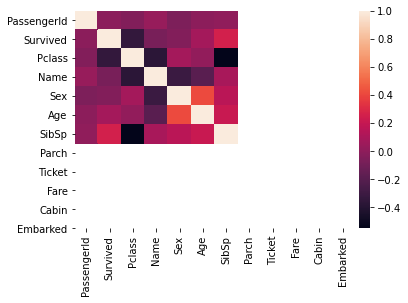

In [4]:
data_frame = pd.read_csv("https://raw.githubusercontent.com/ilya89099/ML1/master/titanic.csv")
df_info(data_frame)
X,y = prepare_dataset(data_frame)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Добавим полезных функций - функцию для всесторонней оценки качества предсказания, и сигмоиду, которая необходима для реализации логистической регрессии.

In [6]:
def score_prediction(y_pred, y_test):
    print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("accuracy:", accuracy_score(y_test, y_pred))
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("f1_score", f1_score(y_test, y_pred))
    
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Сам класс с реализацией Логистической регрессии.

In [7]:
class MyLogisticRegression:
    def __init__(self, lr, max_iter = 10000):
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        X = np.hstack((np.full((X.shape[0], 1), 1),X))
        weights = np.random.rand(X.shape[1])
        for i in range(self.max_iter):
            old_weights = weights.copy()
            weights -= self.lr * np.dot(X.T, sigmoid(np.dot(X, weights)) - y) / len(X)
        self.weights = weights

    def predict(self, X):
        X = X.to_numpy()
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        labels = []
        for row in X:
            labels.append(int(sigmoid(np.dot(row, self.weights)) > 0.5))
        return labels

In [9]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train,y_train)
print("Sklearn implementation accuracy {}".format(accuracy_score(model.predict(X_test), y_test)))


Sklearn implementation accuracy 0.7134831460674157


In [15]:
max_accuracy = 0
max_params = (0,0)
y_pred_max = 0
for lr, max_iter in [(0.1, 100), (0.01, 100), (0.1, 1000), (0.01, 1000), (0.1, 10000), (0.01, 10000)]:
    model = MyLogisticRegression(lr=lr, max_iter=max_iter)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    if acc > max_accuracy:
        max_params = (lr, max_iter)
        max_accuracy = acc
        y_pred_max = y_pred
print("My implementation: max accuracy with learning rate = {} and max iterations = {}"
      .format(*max_params))
score_prediction(y_pred_max, y_test)

My implementation: max accuracy with learning rate = 0.1 and max iterations = 100
confusion matrix:
 [[83 22]
 [28 45]]
accuracy: 0.7191011235955056
precision: 0.6716417910447762
recall: 0.6164383561643836
f1_score 0.6428571428571429


Логистическая регрессия примечательна тем, что она позволяет получать вероятность принадлежности объекта к определенному классу. Логистическая регрессия обучается за счет нахождения максимума правдоподобия на обучающей выборке.

Теперь можно перейти к дереву решений

In [16]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        X = X.to_numpy()
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [19]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Sklearn decision tree accuracy {}".format(accuracy_score(y_test, y_pred)))

model = MyDecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("My implementation score:")
score_prediction(y_pred, y_test)

Sklearn decision tree accuracy 0.7471910112359551
My implementation score:
confusion matrix:
 [[86 19]
 [23 50]]
accuracy: 0.7640449438202247
precision: 0.7246376811594203
recall: 0.684931506849315
f1_score 0.704225352112676


Пришло время перейти к методу опорных векторов.

In [21]:
class MySVM:
    def __init__(self, lr, lambda_, iters):
        self.lr = lr
        self.lambda_ = lambda_
        self.iters = iters

    def fit(self, X, y):
        X = X.to_numpy()
        y = y.to_numpy()
        n = X.shape[0]
        self.W = np.zeros(X.shape[1])
        self.b = 0
        y_ = np.where(y <= 0, -1, 1)

        for i in range(self.iters):
            for j, x in enumerate(X):
                if y_[j] * ((x @ self.W) - self.b) >= 1:
                    self.W -= self.lr * (2 * self.lambda_ * self.W)
                else:
                    self.W -= self.lr * (2 * self.lambda_ * self.W - np.dot(x,y_[j]))
                    self.b -= self.lr * y_[j]

    def predict(self, X):
        X = X.to_numpy()
        res = np.dot(X, self.W) - self.b
        y_pred = np.where(res >= 0, 1, 0)
        return y_pred

In [24]:
model = SVC()
model.fit(X_train, y_train)
print("Sklearn SVM accuracy {}".format(accuracy_score(model.predict(X_test), y_test)))

Sklearn SVM accuracy 0.7471910112359551


In [27]:
max_acc = 0
max_params = (0,0,0)
y_pred = 0
for lr_lambda_iters in [(0.01, 0.01, 5000), (0.001, 0.01, 1000), (0.001, 0.01, 3000)]:
    lr, lambda_, iters = lr_lambda_iters
    model = MySVM(lr=lr, lambda_=lambda_, iters=iters)
    model.fit(X_train, y_train)
    y_pred_cur = model.predict(X_test)
    acc = accuracy_score(y_pred_cur, y_test)
    if acc > max_acc:
        max_acc = acc
        y_pred = y_pred_cur
        max_params = lr_lambda_iters
print("Params with max accuracy lr = {}, lambda = {}, iters = {}".format(*max_params))
score_prediction(y_pred, y_test)


Params with max accuracy lr = 0.01, lambda = 0.01, iters = 5000
confusion matrix:
 [[85 20]
 [30 43]]
accuracy: 0.7191011235955056
precision: 0.6825396825396826
recall: 0.589041095890411
f1_score 0.6323529411764707
